In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  # default is ‘last_expr’

%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
from collections import defaultdict

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

## Load data
land_cover = *Colombia Corine land cover*  
Villavicencio = *Villavicencio boundary*  
tabla_lulc_wcs = *WCS land cover classes*  
wcs_num_to_name = *WCS land cover codes*  

In [14]:
VillavicencioWCS = gpd.read_file(r'C:/Users/ricar/OneDrive/Maestría en Geomática/Percepción remota avanzada/RepositorioClasificaciónCoberturas/Replica/Datos/villavicencioWCS.gpkg')
VillavicencioWCS

,LEYENDA3N,Class_WCS,ID,code,color,area,geometry
0,2.3.1. Pastos limpios,Intensive livestock,8,8,salmon,1939.864172,"MULTIPOLYGON (((4980558.878 1993497.251, 49805..."
1,2.2.3. Cultivos permanentes arboreos,Other permanent arboreal crops,7,7,olive,115.940266,"MULTIPOLYGON (((4980162.85 1994480.755, 498000..."
2,3.1.1. Bosque denso,Dense forest,12,12,darkseagreen,27.210575,"MULTIPOLYGON (((4980526.518 1996705.656, 49804..."
3,2.4.4. Mosaico de pastos con espacios naturales,Other agricultural areas,11,11,darkkhaki,33.861907,"MULTIPOLYGON (((4980572.697 1996925.971, 49805..."
4,3.2.1. Herbazal,Savanna,17,17,gold,29.024968,"MULTIPOLYGON (((4963483.478 1996639.852, 49634..."
...,...,...,...,...,...,...,...
319,"2.4.3. Mosaico de cultivos, pastos y espacios ...",Other agricultural areas,11,11,darkkhaki,26.640216,"MULTIPOLYGON (((4931209.707 2023711.344, 49312..."
320,3.1.3. Bosque fragmentado,Fragmented forest,14,14,lightgreen,15.319226,"MULTIPOLYGON (((4933223.593 2023019.679, 49332..."
321,"2.4.3. Mosaico de cultivos, pastos y espacios ...",Other agricultural areas,11,11,darkkhaki,1398.723990,"MULTIPOLYGON (((4929119.316 2031031.051, 49291..."
322,3.1.3. Bosque fragmentado,Fragmented forest,14,14,lightgreen,470.940211,"MULTIPOLYGON (((4932815.792 2024359.058, 49328..."


In [15]:
class_map = {
    'Urban': 'Urban and infrastructure',
    'Infrastructure': 'Urban and infrastructure',
    'Mining': 'Urban and infrastructure',
    'Other temporary crops': 'Agriculture',
    'Permanent herbaceous crops': 'Agriculture',
    'Other permanent shrubby crops': 'Agriculture',
    'Other permanent arboreal crops': 'Arboreal and forestry crops',
    'Intensive livestock': 'Pasture',
    'Silvopastoral livestock': 'Pasture',
    'Secondary herbaceous vegetation': 'Vegetation',
    'Other agricultural areas': 'Agriculture',
    'Dense forest': 'Forest',
    'Open forest': 'Forest',
    'Fragmented forest': 'Forest',
    'Gallery forest': 'Forest',
    'Forestry crops': 'Arboreal and forestry crops',
    'Savanna': 'Savanna',
    'Shrubland': 'Vegetation',
    'Secondary shrubby/arboreal vegetation': 'Vegetation',
    'Sandy areas': 'Sand, rocks and bare land',
    'Rocks': 'Sand, rocks and bare land',
    'Degraded and bare land': 'Sand, rocks and bare land',
    'Burnt zones': 'Unavailable',
    'Glaciers and snow zones': 'Unavailable',
    'Swamp': 'Swamp',
    'Rivers': 'Water',
    'Lakes, lagoons, and natural cienaga': 'Water',
    'Artificial water bodies': 'Water',
    'Unavailable': 'Unavailable',
    'Rice': 'Agriculture',
    'Palm oil': 'Arboreal and forestry crops',
    'Seasonal savanna': 'Seasonal savanna',
    'Seasonally flooded savanna': 'Seasonally flooded savanna'
}


VillavicencioWCS["Class_WCS_coarse"] = VillavicencioWCS["Class_WCS"].map(class_map)


In [16]:
num_to_class = {
    '1': 'Urban and infrastructure',
    '2': 'Agriculture',
    '3': 'Arboreal and forestry crops',
    '4': 'Pasture',
    '5': 'Vegetation',
    '6': 'Forest',
    '7': 'Savanna',
    '8': 'Sand, rocks and bare land',
    '9': 'Unavailable',
    '10': 'Swamp',
    '11': 'Water',
    '12': 'Seasonal savanna',
    '13': 'Seasonally flooded savanna',
    '0': 'Empty of data'
}

coarse_num_to_color = {
    '0': 'black',
    '1': 'lightgray',
    '2': 'pink',
    '3': 'teal',
    '4': 'salmon',
    '5': 'goldenrod',
    '6': 'darkseagreen',
    '7': 'gold',
    '8': 'blanchedalmond',
    '9': 'whitesmoke',
    '10': 'darkolivegreen',
    '11': 'deepskyblue',
    '12': 'khaki',
    '13': 'thistle'
}


In [17]:
df_class = pd.DataFrame(list(num_to_class.items()), columns=["Code", "Category"])
df_color = pd.DataFrame(list(coarse_num_to_color.items()), columns=["Code", "Color"])

# Unirlos en un solo DataFrame
df_legend = df_class.merge(df_color, on="Code", how="left")

VillavicencioWCS = VillavicencioWCS.merge(
    df_legend,
    how="left",
    left_on="Class_WCS_coarse",   
    right_on="Category"     
)

VillavicencioWCS = VillavicencioWCS[["LEYENDA3N", "Class_WCS_coarse", "Code","geometry", "Color"]]


In [18]:
VillavicencioWCS

,LEYENDA3N,Class_WCS_coarse,Code,geometry,Color
0,2.3.1. Pastos limpios,Pasture,4,"MULTIPOLYGON (((4980558.878 1993497.251, 49805...",salmon
1,2.2.3. Cultivos permanentes arboreos,Arboreal and forestry crops,3,"MULTIPOLYGON (((4980162.85 1994480.755, 498000...",teal
2,3.1.1. Bosque denso,Forest,6,"MULTIPOLYGON (((4980526.518 1996705.656, 49804...",darkseagreen
3,2.4.4. Mosaico de pastos con espacios naturales,Agriculture,2,"MULTIPOLYGON (((4980572.697 1996925.971, 49805...",pink
4,3.2.1. Herbazal,Savanna,7,"MULTIPOLYGON (((4963483.478 1996639.852, 49634...",gold
...,...,...,...,...,...
319,"2.4.3. Mosaico de cultivos, pastos y espacios ...",Agriculture,2,"MULTIPOLYGON (((4931209.707 2023711.344, 49312...",pink
320,3.1.3. Bosque fragmentado,Forest,6,"MULTIPOLYGON (((4933223.593 2023019.679, 49332...",darkseagreen
321,"2.4.3. Mosaico de cultivos, pastos y espacios ...",Agriculture,2,"MULTIPOLYGON (((4929119.316 2031031.051, 49291...",pink
322,3.1.3. Bosque fragmentado,Forest,6,"MULTIPOLYGON (((4932815.792 2024359.058, 49328...",darkseagreen


<Axes: >

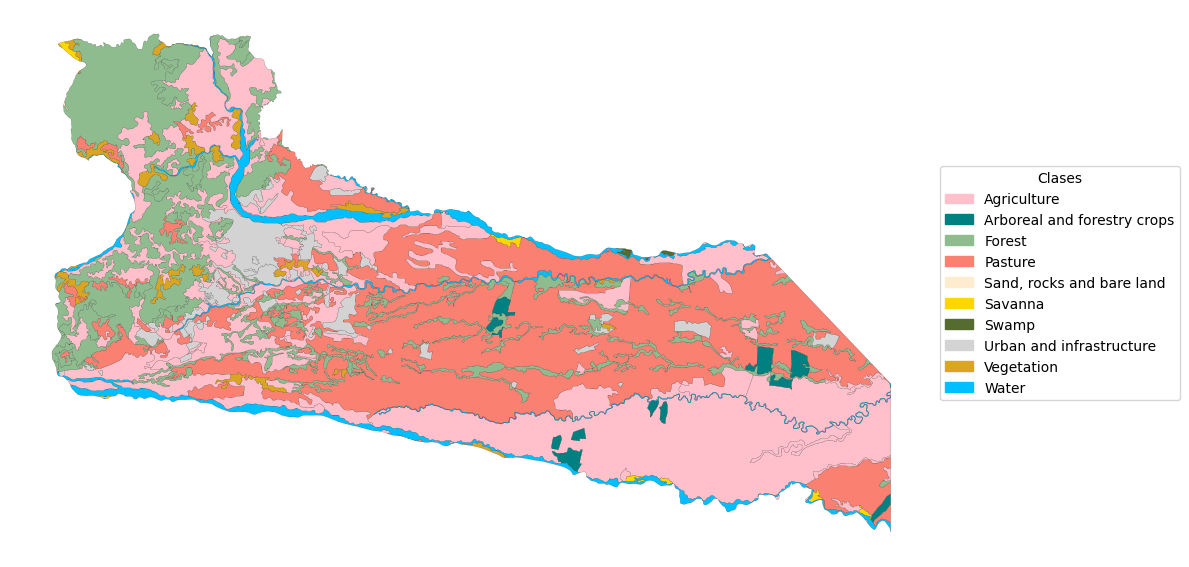

In [21]:

# --- Graficar el GeoDataFrame con los colores ---
fig, ax = plt.subplots(figsize=(12, 10))

VillavicencioWCS.plot(color=VillavicencioWCS["Color"], linewidth=0.1, edgecolor="black", ax=ax)

# --- Crear la leyenda ---
categories = VillavicencioWCS[["Class_WCS_coarse", "Color"]].drop_duplicates().sort_values("Class_WCS_coarse")

# Crear parches para la leyenda
import matplotlib.patches as mpatches
legend_patches = [
    mpatches.Patch(color=row["Color"], label=row["Class_WCS_coarse"])
    for _, row in categories.iterrows()
]

# Colocar la leyenda afuera del mapa
ax.legend(
    handles=legend_patches,
    title="Clases",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=10
)

# Quitar ejes
ax.set_axis_off()

plt.tight_layout()
plt.show()